In [1]:
# 저장소 복제
!git clone https://github.com/ndb796/weather_dataset
# 폴더 이동
%cd weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 10.58 MiB/s, done.
/home/qkrwnstj/anaconda3/envs/pytorch/FastCampus/weather_dataset


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms #for data augmentation 
import torchvision.models as models 
import torchvision.datasets as datasets 
# To change a number of weather folder in dataset

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split # train, validation으로 나누기

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np


In [5]:
transform_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(), #좌우 반전
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5,0.5,0.5],
        std = [0.5,0.5,0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5,0.5,0.5],
        std = [0.5,0.5,0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5,0.5,0.5],
        std = [0.5,0.5,0.5]
    )
])

In [21]:
train_dataset = datasets.ImageFolder(
    root = 'train/',
    transform = transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size*0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size,val_size])
#train_dataset을 2개로 쪼갠다 
test_dataset = datasets.ImageFolder(
    root = 'test/',
    transform = transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

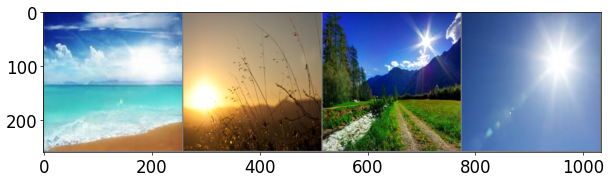

['Shine', 'Sunrise', 'Shine', 'Shine']


In [51]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size' : 20})

def imshow(input):
    #torch.tensor => numpy
    # channel X height X width -> height X width X channel
    input = input.numpy().transpose((1,2,0))
    #undo image normalization
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    input = std * input + mean
    # replace image number between 0 and 1 
    input = np.clip(input,0,1)
    #display images
    plt.imshow(input)
    plt.show()

    
class_names = {
    0 : "Cloudy",
    1 : "Rain",
    2 : "Shine",
    3 : "Sunrise"
}

#load a batch of train image
iterator = iter(train_dataloader)

#visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])


In [40]:
class model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(256*256*3,4)
        self.flatten = nn.Flatten()
    
    def forward(self,x):
        x = self.flatten(x)
        x = self.linear1(x)
        
        return x

class model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(256*256*3,64)
        self.linear2 = nn.Linear(64,4)
        self.flatten = nn.Flatten()
        
    def forward(self,x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x

class model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(256*256*3,128)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128,64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64,32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32,4)
        self.flatten = nn.Flatten()
        
    def forward(self,x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        
        return x

In [33]:
import time

def train():
    start_time = time.time()
    print(f'[Epoch : {epoch+1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    
    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()
        
        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i% log_step == log_step -1:
            print(f'[Batch : {i+1}] running train loss : {running_loss / total}. running train accuracy : {running_corrects / total}')
    
    print(f"trian loss : {running_loss / total}, accuracy : {running_corrects / total}")
    print("elapsed time : ",time.time() - start_time)
    return running_loss / total, (running_corrects/total).item()


def validate():
    start_time = time.time()
    print(f"[Epoch : {epoch +1}- Validation]")
    model.eval()
    total = 0
    running_loss = 0.
    running_corrects = 0
    
    for i, batch in enumerate(val_dataloader):
        imgs,labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()
        
        with torch.no_grad():
            outputs = model(imgs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if(i==0) or (i %log_step == log_step -1):
            print(f"[Batch : {i+1}] running val loss : {running_loss/total}. running val accuracy : {running_corrects /total}")
    
    print(f"val loss : {running_loss /total}, accuracy : {running_corrects/total}")
    print("elapesd time : ",time.time()-start_time)
    return running_loss /total, (running_corrects /total).item()

def test():
    start_time = time.time()
    print(f"[Test]")
    model.eval()
    total = 0
    running_loss = 0.
    running_corrects = 0
    
    for i, batch in enumerate(val_dataloader):
        imgs,labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()
        
        with torch.no_grad():
            outputs = model(imgs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if(i==0) or (i %log_step == log_step -1):
            print(f"[Batch : {i+1}] running test loss : {running_loss/total}. running test accuracy : {running_corrects /total}")
    
    print(f"test loss : {running_loss /total}, accuracy : {running_corrects/total}")
    print("elapesd time : ",time.time()-start_time)
    return running_loss /total, (running_corrects /total).item()
    

In [34]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >=3:
        lr /= 10
    
    if epoch >=7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

[Epoch : 1 - Training]
trian loss : 0.2626693128656458, accuracy : 0.5925925970077515
elapsed time :  2.8353934288024902
[Epoch : 1- Validation]
[Batch : 1] running val loss : 0.16276012361049652. running val accuracy : 0.796875
val loss : 0.3553994364992401, accuracy : 0.7100591659545898
elapesd time :  0.6149516105651855
[info] best validation accuracy!
[Epoch : 2 - Training]
trian loss : 0.26643607951976633, accuracy : 0.6888889074325562
elapsed time :  2.816535711288452
[Epoch : 2- Validation]
[Batch : 1] running val loss : 0.36435675621032715. running val accuracy : 0.6875
val loss : 0.48232262515457425, accuracy : 0.668639063835144
elapesd time :  0.6047406196594238
[Epoch : 3 - Training]
trian loss : 0.23622412434330692, accuracy : 0.7096296548843384
elapsed time :  2.773852586746216
[Epoch : 3- Validation]
[Batch : 1] running val loss : 0.29026585817337036. running val accuracy : 0.71875
val loss : 0.4455665159507616, accuracy : 0.6213017702102661
elapesd time :  0.604278802871

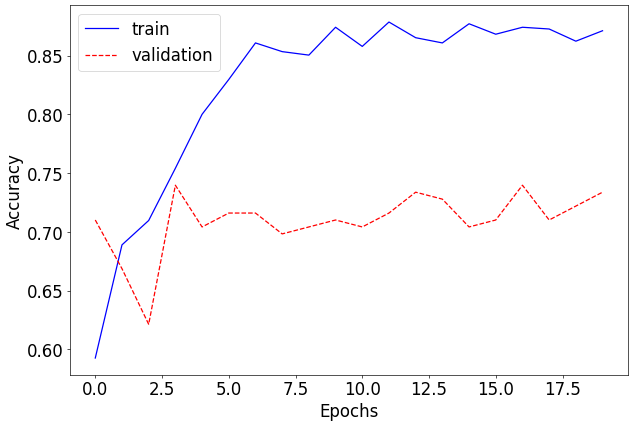

In [35]:
learning_rate = 0.01
log_step = 20

model = model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer,epoch)
    train_loss,train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss,val_loss))
    accuracy.append((train_acc,val_acc))
    
    if val_acc > best_val_acc:
        print("[info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        
plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss:.8f}")
print(f"Test accuracy : {test_accuracy*100.:.2f}%")

[Epoch : 1 - Training]
trian loss : 0.3094249022448504, accuracy : 0.4251851737499237
elapsed time :  2.776951551437378
[Epoch : 1- Validation]
[Batch : 1] running val loss : 0.37946707010269165. running val accuracy : 0.515625
val loss : 0.5037206390200282, accuracy : 0.43195265531539917
elapesd time :  0.5931451320648193
[info] best validation accuracy!
[Epoch : 2 - Training]
trian loss : 0.5020565485071253, accuracy : 0.45333331823349
elapsed time :  2.792241096496582
[Epoch : 2- Validation]
[Batch : 1] running val loss : 0.3540888726711273. running val accuracy : 0.765625
val loss : 0.8382516330515845, accuracy : 0.668639063835144
elapesd time :  0.6111671924591064
[info] best validation accuracy!
[Epoch : 3 - Training]
trian loss : 0.9251527687355324, accuracy : 0.6029629707336426
elapsed time :  2.818178176879883
[Epoch : 3- Validation]
[Batch : 1] running val loss : 1.0968421697616577. running val accuracy : 0.609375
val loss : 1.179428032869418, accuracy : 0.5798816680908203
el

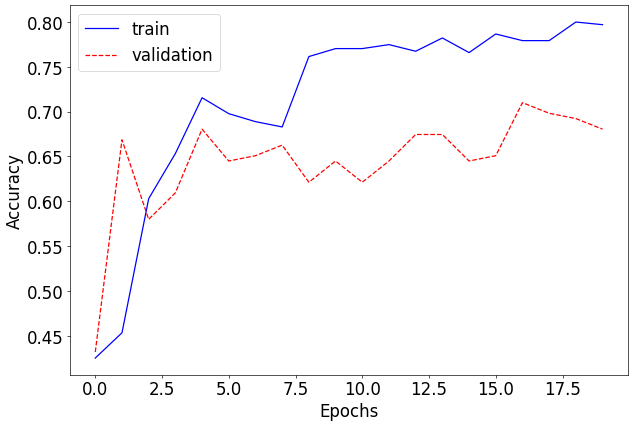

In [38]:
learning_rate = 0.01
log_step = 20

model = model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer,epoch)
    train_loss,train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss,val_loss))
    accuracy.append((train_acc,val_acc))
    
    if val_acc > best_val_acc:
        print("[info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        
plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss:.8f}")
print(f"Test accuracy : {test_accuracy*100.:.2f}%")

[Epoch : 1 - Training]
trian loss : 0.020572070369014032, accuracy : 0.3525925874710083
elapsed time :  2.7769694328308105
[Epoch : 1- Validation]
[Batch : 1] running val loss : 0.013714064843952656. running val accuracy : 0.65625
val loss : 0.017536334384827924, accuracy : 0.5917159914970398
elapesd time :  0.5793218612670898
[info] best validation accuracy!
[Epoch : 2 - Training]
trian loss : 0.01817611305801957, accuracy : 0.46666666865348816
elapsed time :  2.8332631587982178
[Epoch : 2- Validation]
[Batch : 1] running val loss : 0.010555848479270935. running val accuracy : 0.78125
val loss : 0.014874360265111077, accuracy : 0.6745561957359314
elapesd time :  0.5914595127105713
[info] best validation accuracy!
[Epoch : 3 - Training]
trian loss : 0.0165319561958313, accuracy : 0.5407407283782959
elapsed time :  2.820708751678467
[Epoch : 3- Validation]
[Batch : 1] running val loss : 0.008496280759572983. running val accuracy : 0.828125
val loss : 0.013380533492071389, accuracy : 0.7

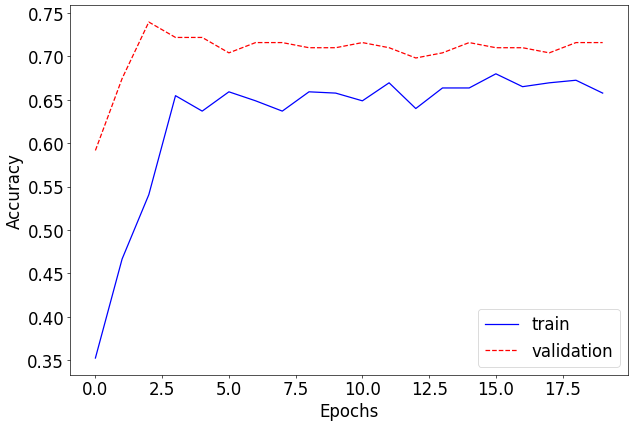

In [41]:
learning_rate = 0.01
log_step = 20

model = model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer,epoch)
    train_loss,train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss,val_loss))
    accuracy.append((train_acc,val_acc))
    
    if val_acc > best_val_acc:
        print("[info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        
plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss:.8f}")
print(f"Test accuracy : {test_accuracy*100.:.2f}%")

In [52]:
learning_rate = 0.01
log_step = 20

model = models.resnet50(pretrained = True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,4) #transfer learning
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/qkrwnstj/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [57]:
num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer,epoch)
    train_loss,train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss,val_loss))
    accuracy.append((train_acc,val_acc))
    
    if val_acc > best_val_acc:
        print("[info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        
plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss:.8f}")
print(f"Test accuracy : {test_accuracy*100.:.2f}%")

[Epoch : 1 - Training]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 7.79 GiB total capacity; 6.23 GiB already allocated; 32.12 MiB free; 6.32 GiB reserved in total by PyTorch)